# Solve the problem leveraging VGG16 architecture
In this notebook, we will use the VGG16 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on ImageNet we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics

## Load Dataset from Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/My Drive/SplittedDataset.zip" -d "/content"

## Set Parameters

In [4]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/vgg19"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [5]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [6]:
set_seed()

Below, we report the number of images for each of the two classes (normal vs cancer) in the training set and validation set.

In [7]:
num_all_tr = len(os.listdir(TRAINING_ALL_PATH))
num_hem_tr = len(os.listdir(TRAINING_HEM_PATH))

num_all_val = len(os.listdir(VALIDATION_PATH + "/all"))
num_hem_val = len(os.listdir(VALIDATION_PATH + "/hem"))

total_train = num_all_tr + num_hem_tr
total_val = num_all_val + num_hem_val

In [8]:
print('total training cancer cell images:', num_all_tr)
print('total training normal cell images:', num_hem_tr)

print('total validation cancer cell images:', num_all_val)
print('total validation normal cell images:', num_hem_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cancer cell images: 3198
total training normal cell images: 3198
total validation cancer cell images: 1403
total validation normal cell images: 729
--
Total training images: 6396
Total validation images: 2132


At this point we need to transform the images we have on disk into preprocessed tensors.

We decided to use the size that VGG16 expects as input, which is 224x224, and to use batches of size 32.

In [9]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature Extraction
This first set of experiments is based on using the architecture of VGG16 simply as a feature extractor.

Let's instantiate the VGG16 model:

In [10]:
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Since we want to perform feature extraction only, we need to "freeze" the convolutional basis.

In [12]:
conv_base.trainable = False

At this point, we can concatenate a binary classifier to the frozen convolutional basis.
### Experiment 1: vanilla
This first version is very simple since we connect directly to the convolutional basis a fully connected layer whose 256 neurons feed the output layer containing a single neuron with sigmoidal activation function.

In [14]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vanilla_vgg_model = keras.Model(inputs, outputs)
compile_model(vanilla_vgg_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 22.5684 - accuracy: 0.6739
Epoch 1: val_loss improved from inf to 6.96774, saving model to /content/models/experiment1_feature_extraction_vanilla.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 57s 239ms/step - loss: 22.5684 - accuracy: 0.6739 - val_loss: 6.9677 - val_accuracy: 0.6417
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 1.4930 - accuracy: 0.8222
Epoch 2: val_loss improved from 6.96774 to 2.99104, saving model to /content/models/experiment1_feature_extraction_vanilla.h5
200/200 [==============================] - 39s 193ms/step - loss: 1.4930 - accuracy: 0.8222 - val_loss: 2.9910 - val_accuracy: 0.5811
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8901
Epoch 3: val_loss improved from 2.99104 to 0.81667, saving model to /content/models/experiment1_feature_extraction_vanilla.h5
200/200 [==============================] - 40s 197ms/step - loss: 0.3410 - accuracy: 0.8901 - val_loss: 0.8167 - val_accuracy: 0.7528
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9193
Epoch 4: val_loss improved from 0.81667 to 0.76809, sa

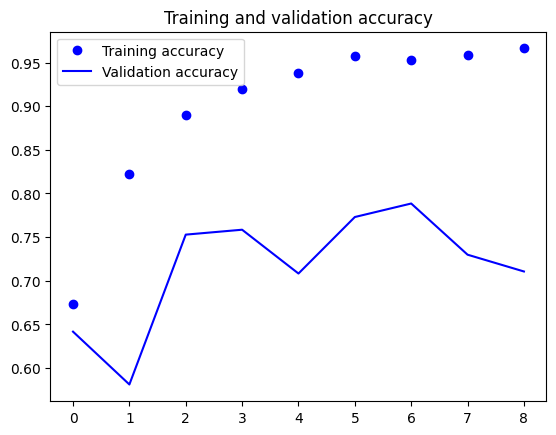

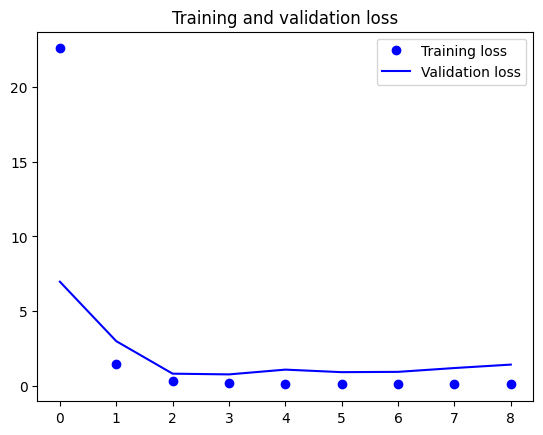

In [ ]:
run_model(vanilla_vgg_model, 'experiment1_feature_extraction_vanilla', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 14s 215ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.5924    0.8060    0.6829       696
           1     0.8862    0.7314    0.8014      1437

    accuracy                         0.7557      2133
   macro avg     0.7393    0.7687    0.7421      2133
weighted avg     0.7903    0.7557    0.7627      2133



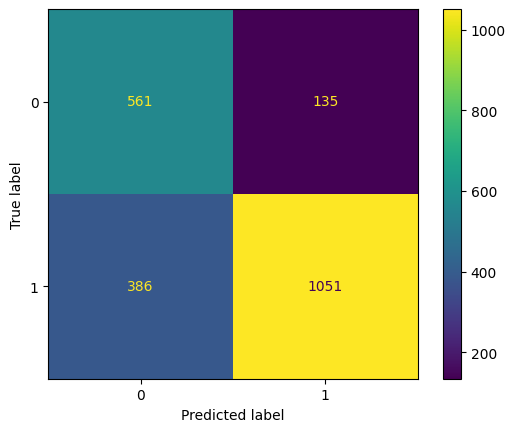

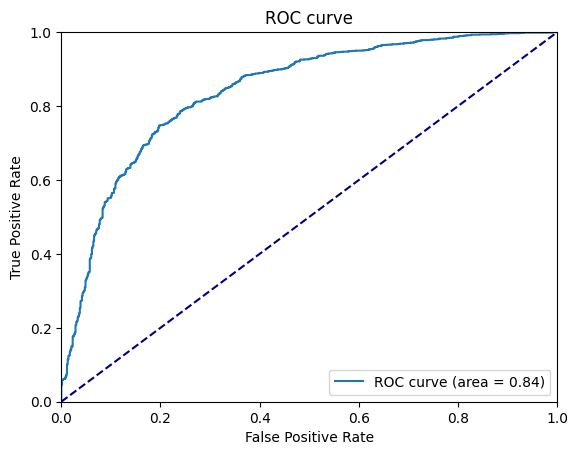

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction_vanilla.h5'))

### Experiment 2: adding dropout
Not surprisingly, the vanilla model performs very poorly and suffers highly from overfitting. We try to solve this problem by adding dropout.

In [15]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
dropout_vgg_model = keras.Model(inputs, outputs)
compile_model(dropout_vgg_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 27.3174 - accuracy: 0.6618
Epoch 1: val_loss improved from inf to 15.40362, saving model to /content/models/experiment2_feature_extraction_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 44s 208ms/step - loss: 27.3174 - accuracy: 0.6618 - val_loss: 15.4036 - val_accuracy: 0.6252
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 9.1564 - accuracy: 0.7511
Epoch 2: val_loss improved from 15.40362 to 5.52104, saving model to /content/models/experiment2_feature_extraction_dropout.h5
200/200 [==============================] - 41s 202ms/step - loss: 9.1564 - accuracy: 0.7511 - val_loss: 5.5210 - val_accuracy: 0.7744
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 4.7274 - accuracy: 0.7971
Epoch 3: val_loss improved from 5.52104 to 4.27318, saving model to /content/models/experiment2_feature_extraction_dropout.h5
200/200 [==============================] - 41s 205ms/step - loss: 4.7274 - accuracy: 0.7971 - val_loss: 4.2732 - val_accuracy: 0.8063
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 2.0567 - accuracy: 0.8419
Epoch 4: val_loss improved from 4.27318 to 2.73214, 

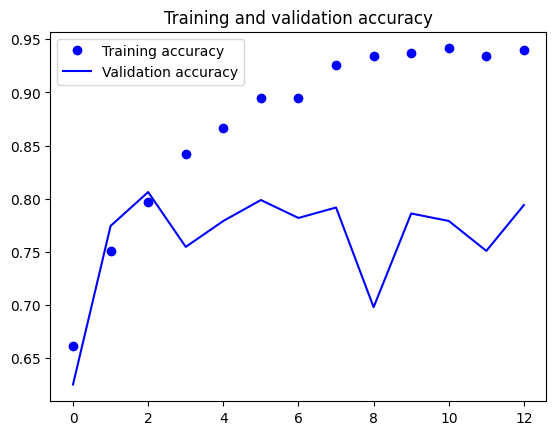

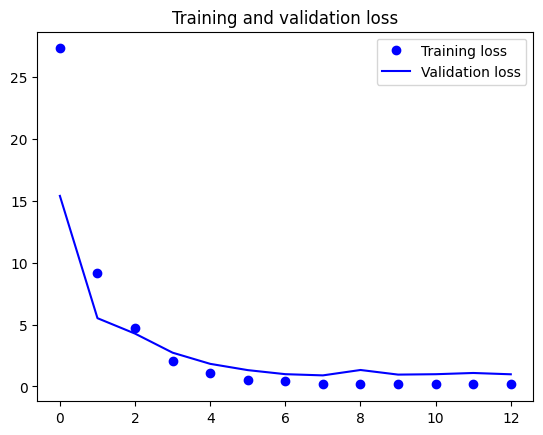

In [ ]:
run_model(dropout_vgg_model, 'experiment2_feature_extraction_dropout', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 149ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6358    0.7902    0.7047       696
           1     0.8849    0.7808    0.8296      1437

    accuracy                         0.7839      2133
   macro avg     0.7603    0.7855    0.7671      2133
weighted avg     0.8036    0.7839    0.7888      2133



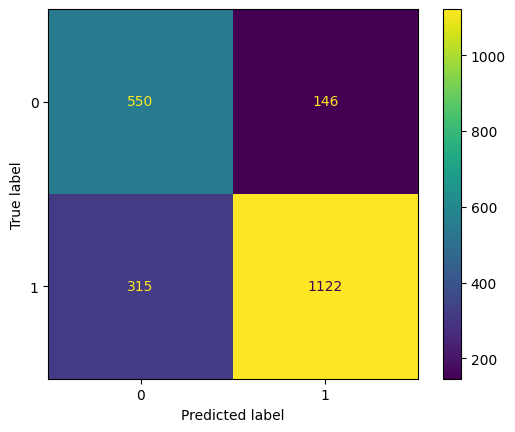

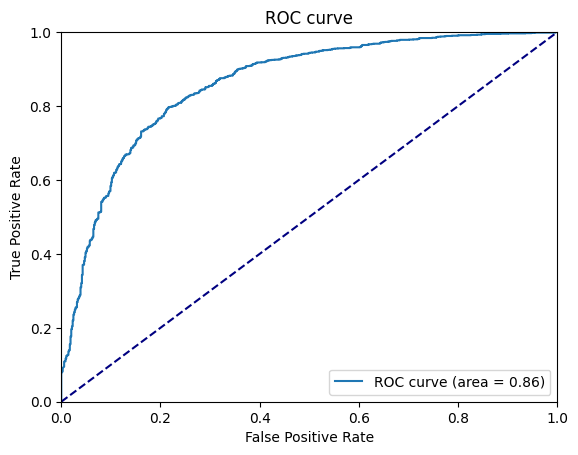

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction_dropout.h5'))

### Experiment 3: global average pooling

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
global_average = keras.Model(inputs, outputs)
compile_model(global_average)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 1.4249 - accuracy: 0.6437
Epoch 1: val_loss improved from inf to 0.60444, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 43s 207ms/step - loss: 1.4249 - accuracy: 0.6437 - val_loss: 0.6044 - val_accuracy: 0.7786
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.6845
Epoch 2: val_loss improved from 0.60444 to 0.57926, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 52s 258ms/step - loss: 0.7912 - accuracy: 0.6845 - val_loss: 0.5793 - val_accuracy: 0.7176
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.7120
Epoch 3: val_loss improved from 0.57926 to 0.53859, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 40s 199ms/step - loss: 0.6561 - accuracy: 0.7120 - val_loss: 0.5386 - val_accuracy: 0.7247
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7198
Epoch 4: val_loss improved from 0.53859 to 0.46051, saving model to /content/models/experiment3_feature_extraction_gap.h5
200/200 [==============================] - 41s 203ms/step - loss: 0.5839 - accuracy: 0.

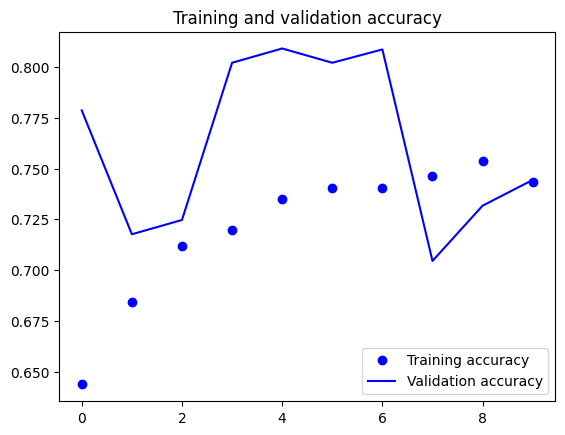

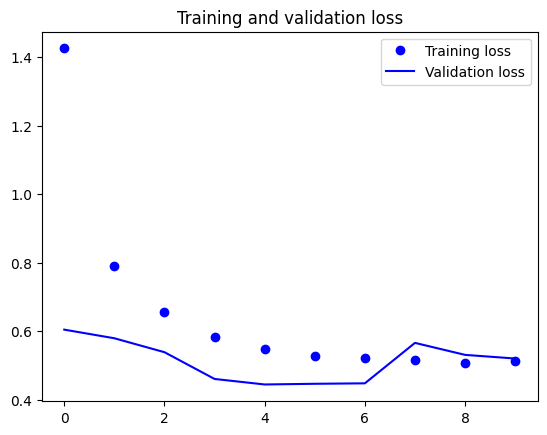

In [ ]:
run_model(global_average, 'experiment3_feature_extraction_gap', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 150ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7150    0.6595    0.6861       696
           1     0.8410    0.8727    0.8566      1437

    accuracy                         0.8031      2133
   macro avg     0.7780    0.7661    0.7713      2133
weighted avg     0.7999    0.8031    0.8009      2133



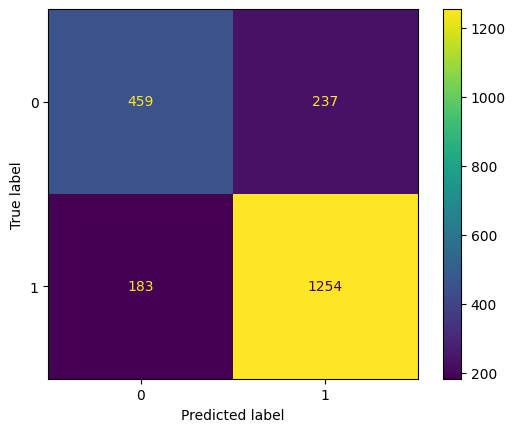

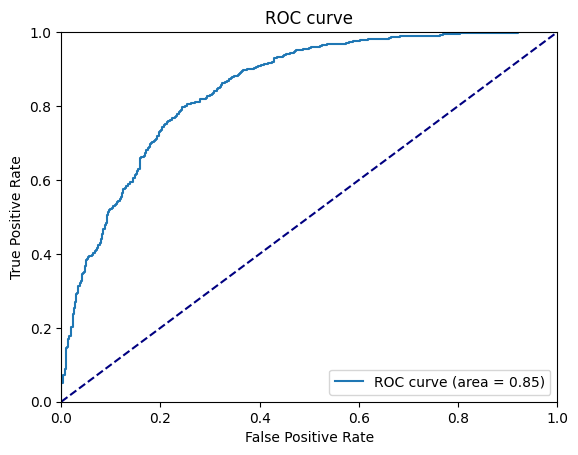

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction_gap.h5'))

## Fine Tuning
At this point, we try to unfreeze a few layers of the network and re-run the training to increase performance.

### Experiment 4: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg19').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9364
Epoch 1: val_loss improved from inf to 0.82777, saving model to /content/models/experiment4_finetuning_1_layer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 47s 222ms/step - loss: 0.1648 - accuracy: 0.9364 - val_loss: 0.8278 - val_accuracy: 0.7974
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9564
Epoch 2: val_loss did not improve from 0.82777
200/200 [==============================] - 42s 209ms/step - loss: 0.1090 - accuracy: 0.9564 - val_loss: 0.8790 - val_accuracy: 0.7842
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9676
Epoch 3: val_loss did not improve from 0.82777
200/200 [==============================] - 42s 208ms/step - loss: 0.0876 - accuracy: 0.9676 - val_loss: 0.9147 - val_accuracy: 0.7716
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9767
Epoch 4: val_loss did not improve from 0.82777
200/200 [==============================] - 42s 211ms/step - loss: 0.0653 - accuracy: 0.9767 - val_loss: 0.9149 - val_accuracy: 0.7795
Epoch 5/100
200/200 [===========

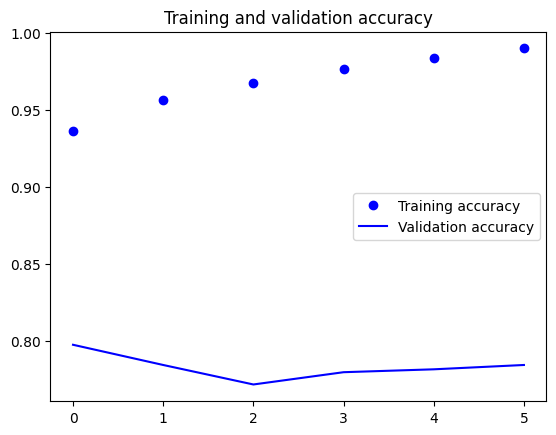

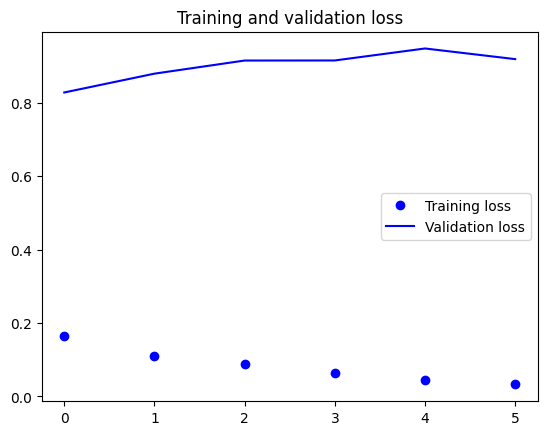

In [ ]:
run_model(vgg_ft_1_layer, 'experiment4_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 143ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6554    0.7787    0.7118       696
           1     0.8821    0.8017    0.8400      1437

    accuracy                         0.7942      2133
   macro avg     0.7687    0.7902    0.7759      2133
weighted avg     0.8081    0.7942    0.7981      2133



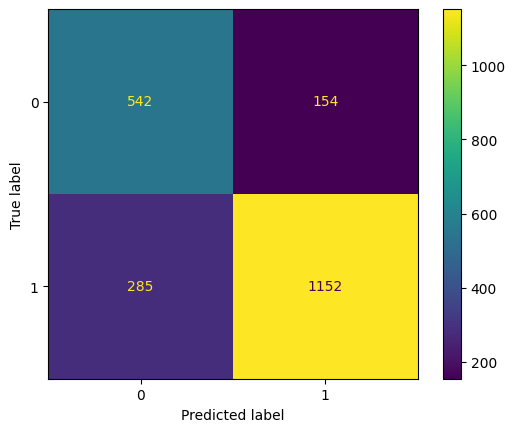

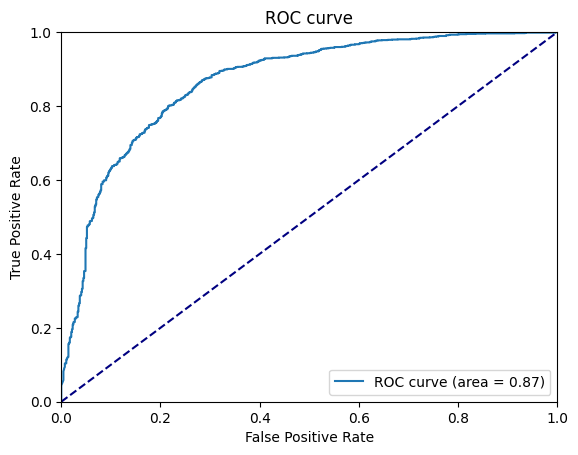

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_finetuning_1_layer.h5'))

### Experiment 4bis: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg19').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.7598
Epoch 1: val_loss improved from inf to 0.44341, saving model to /content/models/experiment4bis_finetuning_1_layer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 64s 262ms/step - loss: 0.4902 - accuracy: 0.7598 - val_loss: 0.4434 - val_accuracy: 0.8039
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.7897
Epoch 2: val_loss improved from 0.44341 to 0.42143, saving model to /content/models/experiment4bis_finetuning_1_layer.h5
200/200 [==============================] - 44s 217ms/step - loss: 0.4483 - accuracy: 0.7897 - val_loss: 0.4214 - val_accuracy: 0.8185
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8071
Epoch 3: val_loss did not improve from 0.42143
200/200 [==============================] - 43s 215ms/step - loss: 0.4108 - accuracy: 0.8071 - val_loss: 0.4329 - val_accuracy: 0.8091
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8277
Epoch 4: val_loss did not improve from 0.42143
200/200 [==============================] - 53s 266ms/step - loss: 0.3827 - accuracy: 0.8277 

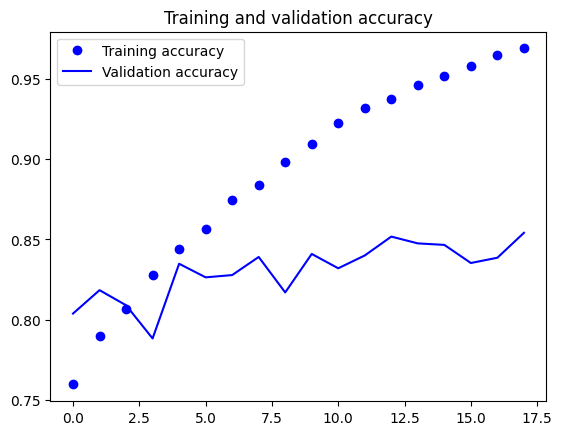

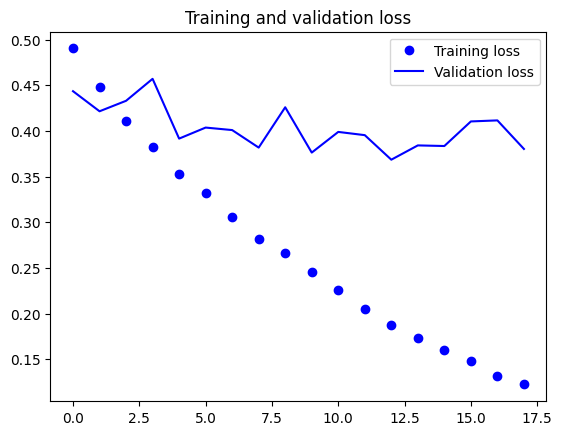

In [ ]:
run_model(vgg_ft_1_layer, 'experiment4bis_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 15s 221ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7564    0.8075    0.7811       696
           1     0.9036    0.8740    0.8886      1437

    accuracy                         0.8523      2133
   macro avg     0.8300    0.8408    0.8348      2133
weighted avg     0.8556    0.8523    0.8535      2133



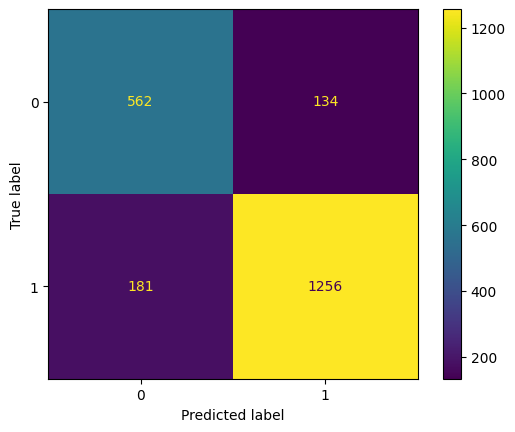

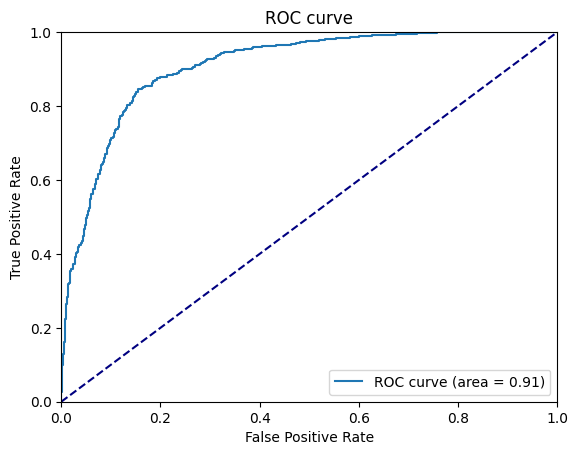

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4bis_finetuning_1_layer.h5'))

### Experiment 5: last block

In [ ]:
vgg16_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg16_ft_1_block.get_layer('vgg19').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_1_block.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9176
Epoch 1: val_loss improved from inf to 1.00401, saving model to /content/models/experiment5_finetuning_1_block.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 51s 239ms/step - loss: 0.2283 - accuracy: 0.9176 - val_loss: 1.0040 - val_accuracy: 0.7406
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9539
Epoch 2: val_loss improved from 1.00401 to 0.74511, saving model to /content/models/experiment5_finetuning_1_block.h5
200/200 [==============================] - 57s 284ms/step - loss: 0.1174 - accuracy: 0.9539 - val_loss: 0.7451 - val_accuracy: 0.7955
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9748
Epoch 3: val_loss did not improve from 0.74511
200/200 [==============================] - 46s 231ms/step - loss: 0.0647 - accuracy: 0.9748 - val_loss: 1.0388 - val_accuracy: 0.7575
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9831
Epoch 4: val_loss did not improve from 0.74511
200/200 [==============================] - 46s 230ms/step - loss: 0.0457 - accuracy: 0.9831 - v

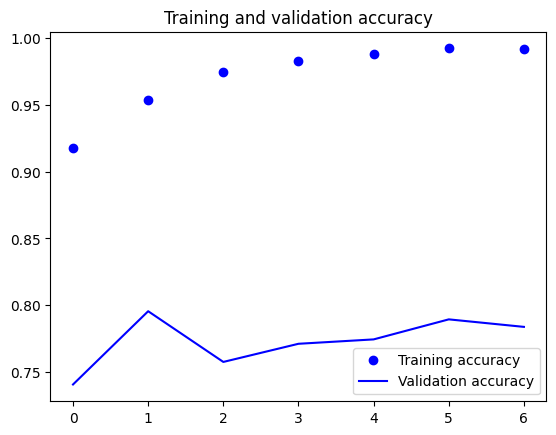

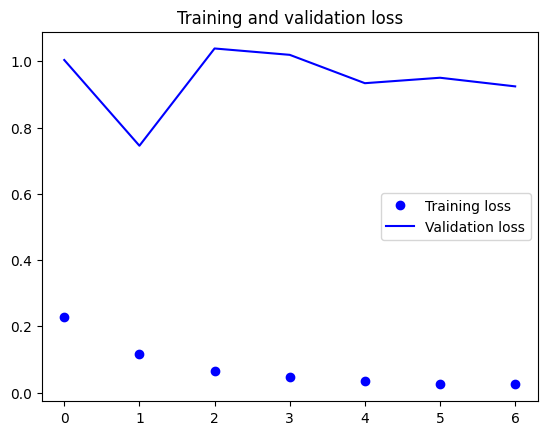

In [ ]:
run_model(vgg16_ft_1_block, 'experiment5_finetuning_1_block', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 152ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6809    0.7328    0.7059       696
           1     0.8656    0.8337    0.8493      1437

    accuracy                         0.8008      2133
   macro avg     0.7733    0.7832    0.7776      2133
weighted avg     0.8053    0.8008    0.8025      2133



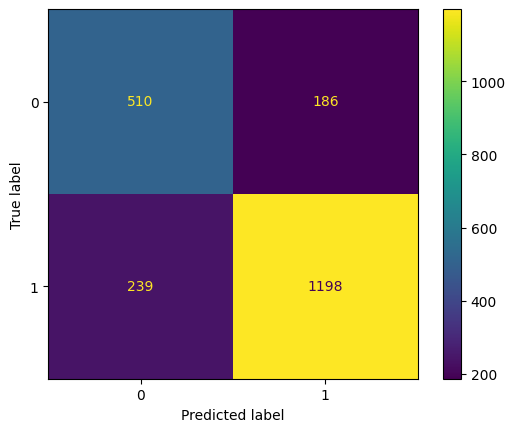

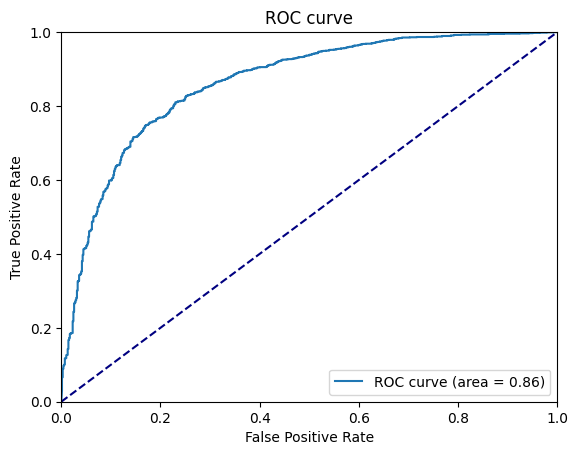

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5_finetuning_1_block.h5'))

### Experiment 5bis: last block (Global Average Pooling)

In [ ]:
vgg16_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg16_ft_1_block.get_layer('vgg19').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_1_block.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.7563
Epoch 1: val_loss improved from inf to 0.40798, saving model to /content/models/experiment5bis_finetuning_1_block.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 48s 230ms/step - loss: 0.4984 - accuracy: 0.7563 - val_loss: 0.4080 - val_accuracy: 0.8349
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8099
Epoch 2: val_loss did not improve from 0.40798
200/200 [==============================] - 46s 229ms/step - loss: 0.4035 - accuracy: 0.8099 - val_loss: 0.4392 - val_accuracy: 0.8100
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8504
Epoch 3: val_loss did not improve from 0.40798
200/200 [==============================] - 47s 232ms/step - loss: 0.3305 - accuracy: 0.8504 - val_loss: 0.4110 - val_accuracy: 0.8213
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8931
Epoch 4: val_loss improved from 0.40798 to 0.36304, saving model to /content/models/experiment5bis_finetuning_1_block.h5
200/200 [==============================] - 57s 283ms/step - loss: 0.2637 - accuracy: 0.8931 

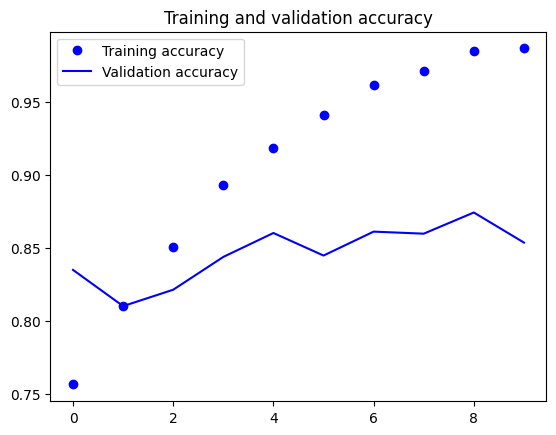

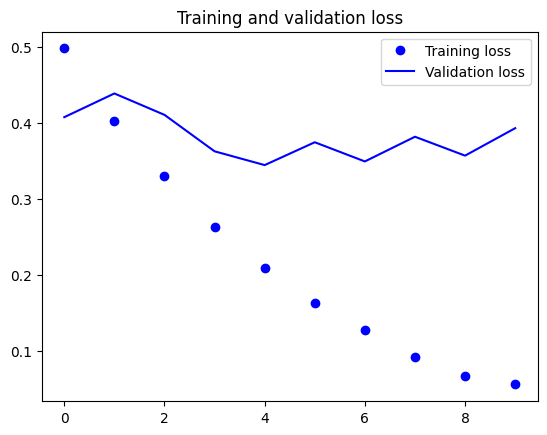

In [ ]:
run_model(vgg16_ft_1_block, 'experiment5bis_finetuning_1_block', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 149ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7577    0.8175    0.7865       696
           1     0.9081    0.8733    0.8904      1437

    accuracy                         0.8551      2133
   macro avg     0.8329    0.8454    0.8384      2133
weighted avg     0.8590    0.8551    0.8565      2133



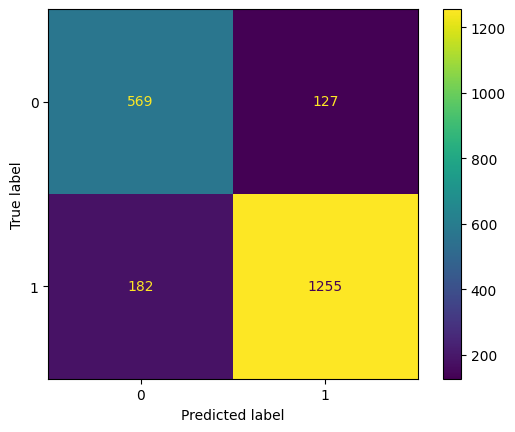

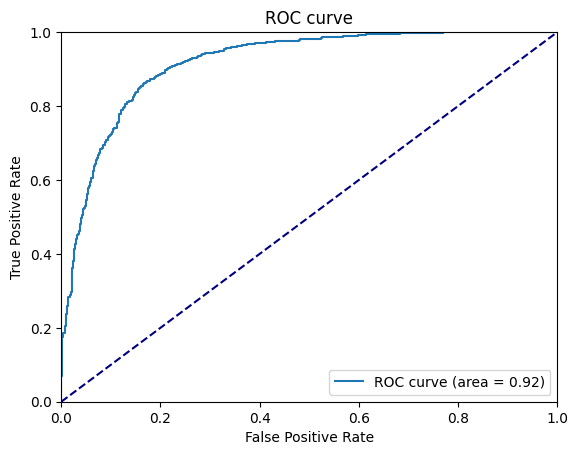

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5bis_finetuning_1_block.h5'))

### Experiment 6: two blocks

In [ ]:
vgg16_ft_2_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg16_ft_2_blocks.get_layer('vgg19').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.8927
Epoch 1: val_loss improved from inf to 0.69424, saving model to /content/models/experiment6_finetuning_2_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 89s 368ms/step - loss: 0.2916 - accuracy: 0.8927 - val_loss: 0.6942 - val_accuracy: 0.7903
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9367
Epoch 2: val_loss improved from 0.69424 to 0.69281, saving model to /content/models/experiment6_finetuning_2_blocks.h5
200/200 [==============================] - 55s 274ms/step - loss: 0.1525 - accuracy: 0.9367 - val_loss: 0.6928 - val_accuracy: 0.7997
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9640
Epoch 3: val_loss did not improve from 0.69281
200/200 [==============================] - 55s 275ms/step - loss: 0.0955 - accuracy: 0.9640 - val_loss: 0.7504 - val_accuracy: 0.7861
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9742
Epoch 4: val_loss did not improve from 0.69281
200/200 [==============================] - 56s 278ms/step - loss: 0.0672 - accuracy: 0.9742 - 

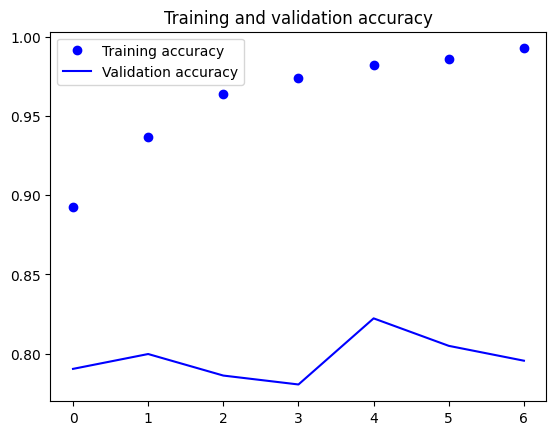

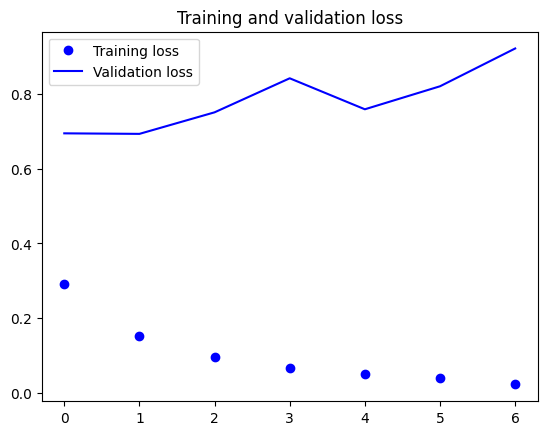

In [ ]:
run_model(vgg16_ft_2_blocks, 'experiment6_finetuning_2_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 14s 214ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6841    0.7500    0.7156       696
           1     0.8730    0.8323    0.8522      1437

    accuracy                         0.8054      2133
   macro avg     0.7786    0.7911    0.7839      2133
weighted avg     0.8114    0.8054    0.8076      2133



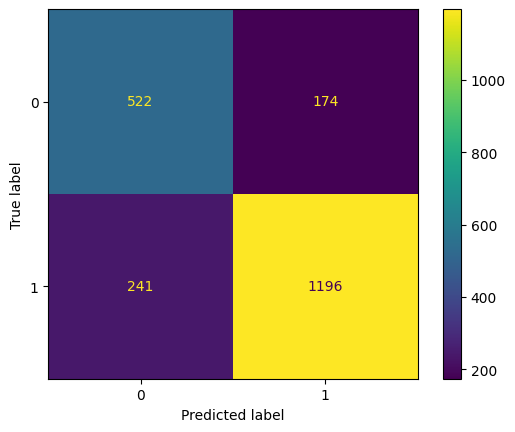

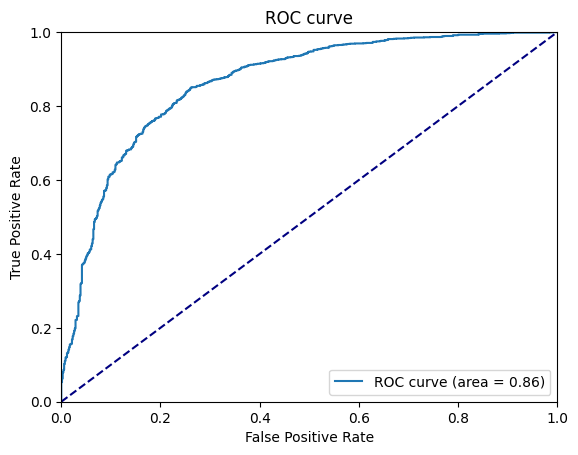

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6_finetuning_2_blocks.h5'))

### Experiment 6bis: two blocks (Global Average Pooling)

In [ ]:
vgg16_ft_2_blocks_gap = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction_gap.h5'))

for layer in vgg16_ft_2_blocks_gap.get_layer('vgg19').layers:
    if layer.name in ('block5_conv2', 'block5_conv3', 'block5_conv1', 'block4_conv3', 'block4_conv2', 'block4_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg16_ft_2_blocks_gap, learning_rate=1e-5)

for i, layer in enumerate(vgg16_ft_2_blocks_gap.get_layer('vgg19').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.7559
Epoch 1: val_loss improved from inf to 0.41601, saving model to /content/models/experiment6bis_finetuning_2_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 60s 287ms/step - loss: 0.4940 - accuracy: 0.7559 - val_loss: 0.4160 - val_accuracy: 0.8227
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8275
Epoch 2: val_loss did not improve from 0.41601
200/200 [==============================] - 68s 339ms/step - loss: 0.3811 - accuracy: 0.8275 - val_loss: 0.4251 - val_accuracy: 0.8194
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8748
Epoch 3: val_loss improved from 0.41601 to 0.34900, saving model to /content/models/experiment6bis_finetuning_2_blocks.h5
200/200 [==============================] - 59s 293ms/step - loss: 0.2863 - accuracy: 0.8748 - val_loss: 0.3490 - val_accuracy: 0.8527
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9170
Epoch 4: val_loss did not improve from 0.34900
200/200 [==============================] - 69s 347ms/step - loss: 0.2154 - accuracy: 0.9170

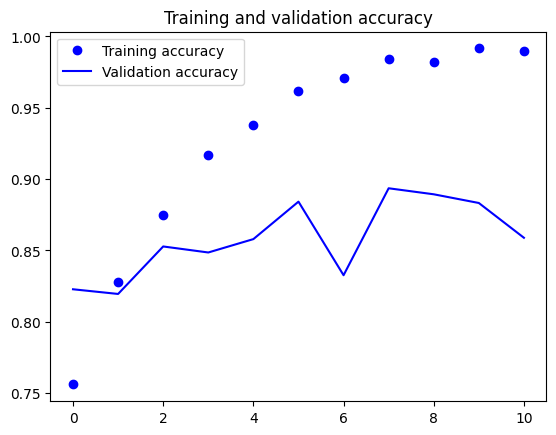

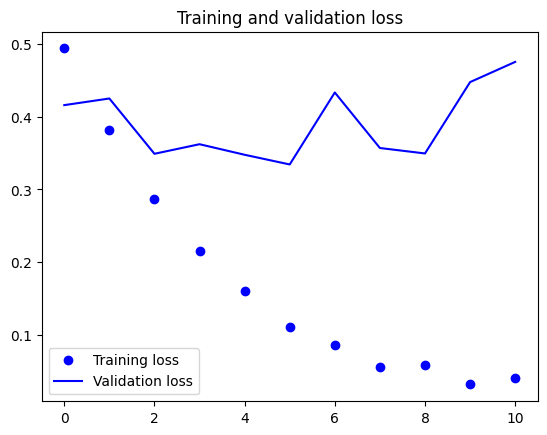

In [ ]:
run_model(vgg16_ft_2_blocks_gap, 'experiment6bis_finetuning_2_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 10s 150ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7760    0.8563    0.8142       696
           1     0.9267    0.8803    0.9029      1437

    accuracy                         0.8725      2133
   macro avg     0.8514    0.8683    0.8586      2133
weighted avg     0.8776    0.8725    0.8740      2133



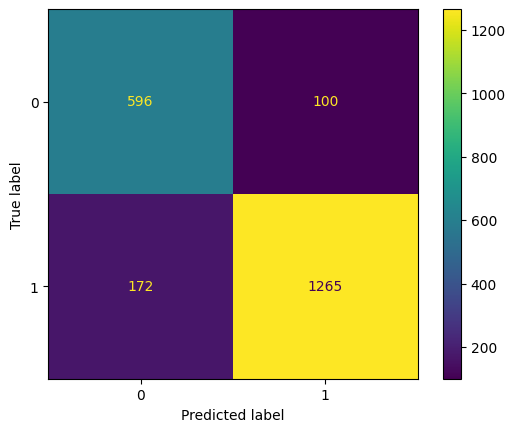

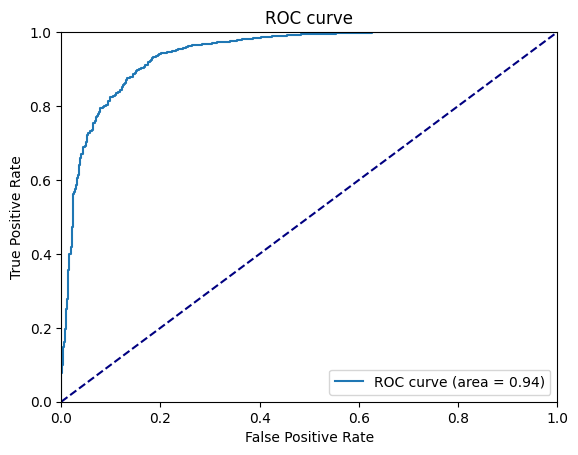

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6bis_finetuning_2_blocks.h5'))

## Remove Last Block
Since our dataset is small and very different from ImageNet, we try to remove the last block. In fact, that block should be able to extract features more specific to the images in the original dataset, which therefore may not be suitable for our medical imaging dataset.

We then repeat the same steps as before, gradually increasing the complexity of the network.

### Feature Extraction

#### Experiment 7: one FC layer with dropout

In [ ]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ("block5_conv1"):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 31.9285 - accuracy: 0.6368
Epoch 1: val_loss improved from inf to 7.24182, saving model to /content/models/experiment7_cut_feature_extraction_dropout.h5
200/200 [==============================] - 39s 186ms/step - loss: 31.9285 - accuracy: 0.6368 - val_loss: 7.2418 - val_accuracy: 0.7350
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 12.2417 - accuracy: 0.6951
Epoch 2: val_loss did not improve from 7.24182
200/200 [==============================] - 38s 188ms/step - loss: 12.2417 - accuracy: 0.6951 - val_loss: 7.9532 - val_accuracy: 0.7791
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 8.9616 - accuracy: 0.7059
Epoch 3: val_loss did not improve from 7.24182
200/200 [==============================] - 38s 188ms/step - loss: 8.9616 - accuracy: 0.7059 - val_loss: 8.0124 - val_accuracy: 0.5985
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 7.6473 - accuracy: 0.6953
Epoch 4: val_loss improved from 7.24182 to 3.02120, saving model to /content/models/experiment7_cut_feature_extraction_dropout.h5
200/200 [==============================] - 38s 190ms/step - loss: 7.6473 - accuracy: 0.6953 - val_loss: 3.0212 - val_accuracy: 0.7167
Epoch 5/100
200/200 [==============================] - ETA: 0s - loss: 3.5270 - accuracy: 0.7

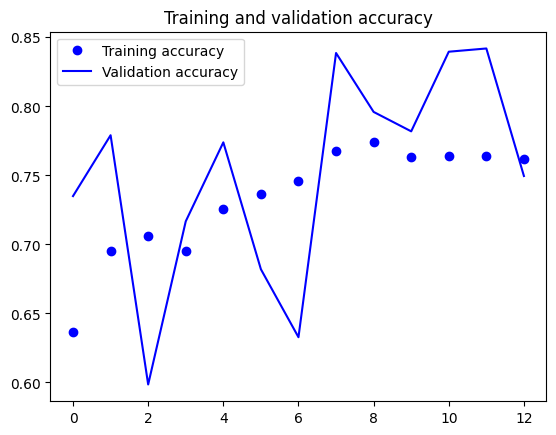

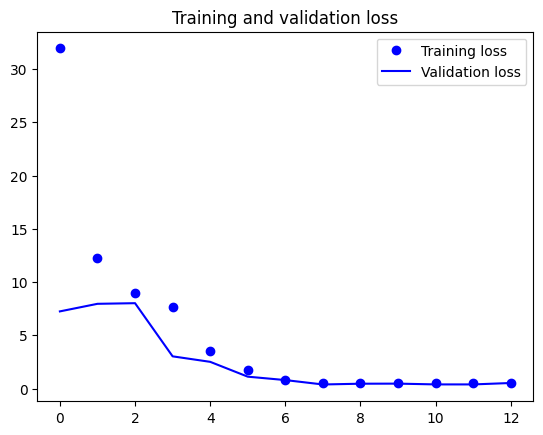

In [ ]:
run_model(vgg_cut_model, 'experiment7_cut_feature_extraction_dropout', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 141ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7668    0.7371    0.7516       696
           1     0.8750    0.8914    0.8831      1437

    accuracy                         0.8411      2133
   macro avg     0.8209    0.8143    0.8174      2133
weighted avg     0.8397    0.8411    0.8402      2133



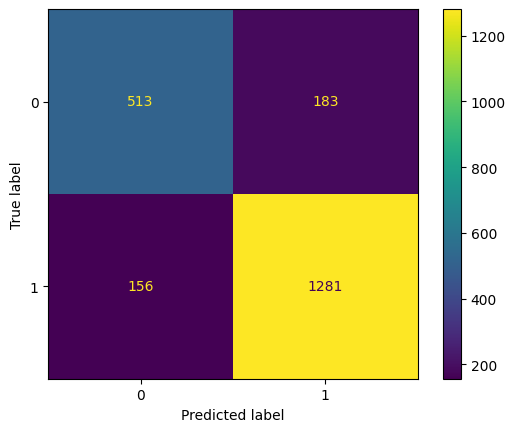

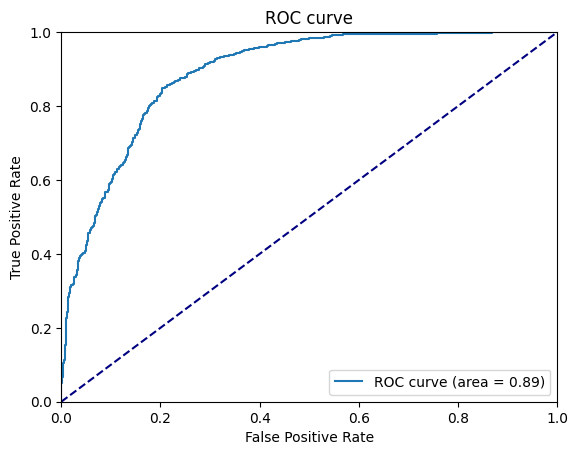

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment7_cut_feature_extraction_dropout.h5'))

#### Experiment 8: RMSprop

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model = keras.Model(inputs, outputs)
compile_model(vgg_cut_model, optimizer="rmsprop", learning_rate = 5e-5)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 2.9777 - accuracy: 0.7391
Epoch 1: val_loss improved from inf to 1.46983, saving model to /content/models/experiment8_cut_feature_extraction_dropout_rms.h5
200/200 [==============================] - 37s 182ms/step - loss: 2.9777 - accuracy: 0.7391 - val_loss: 1.4698 - val_accuracy: 0.8429


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 2.9023 - accuracy: 0.7445
Epoch 2: val_loss did not improve from 1.46983
200/200 [==============================] - 38s 188ms/step - loss: 2.9023 - accuracy: 0.7445 - val_loss: 5.2717 - val_accuracy: 0.5145
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 2.7631 - accuracy: 0.7403
Epoch 3: val_loss improved from 1.46983 to 1.14806, saving model to /content/models/experiment8_cut_feature_extraction_dropout_rms.h5
200/200 [==============================] - 37s 186ms/step - loss: 2.7631 - accuracy: 0.7403 - val_loss: 1.1481 - val_accuracy: 0.8293
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 2.8066 - accuracy: 0.7328
Epoch 4: val_loss did not improve from 1.14806
200/200 [==============================] - 38s 191ms/step - loss: 2.8066 - accuracy: 0.7328 - val_loss: 3.0175 - val_accuracy: 0.6393
Epoch 5/100
200/200 [==============================] - ETA: 0s - loss: 2.6528 -

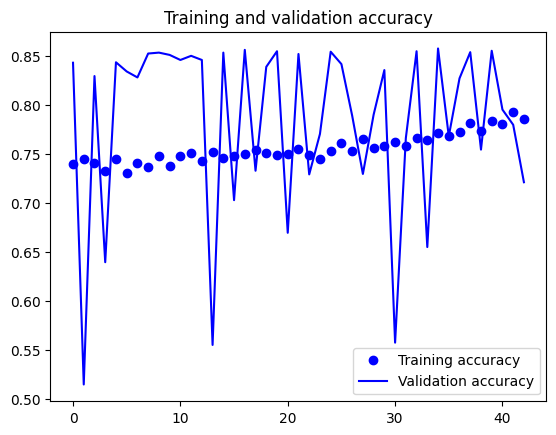

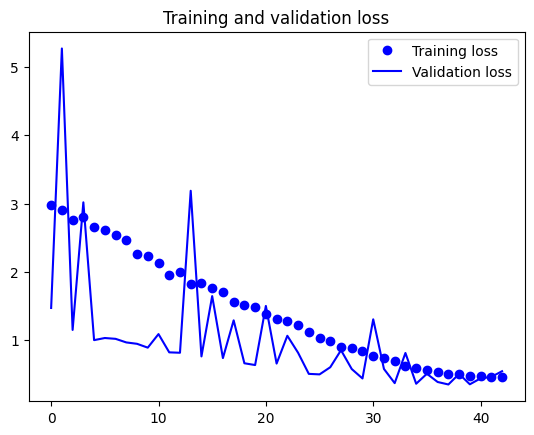

In [ ]:
run_model(vgg_cut_model, 'experiment8_cut_feature_extraction_dropout_rms', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 20s 186ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8019    0.7270    0.7626       696
           1     0.8735    0.9130    0.8928      1437

    accuracy                         0.8523      2133
   macro avg     0.8377    0.8200    0.8277      2133
weighted avg     0.8501    0.8523    0.8503      2133



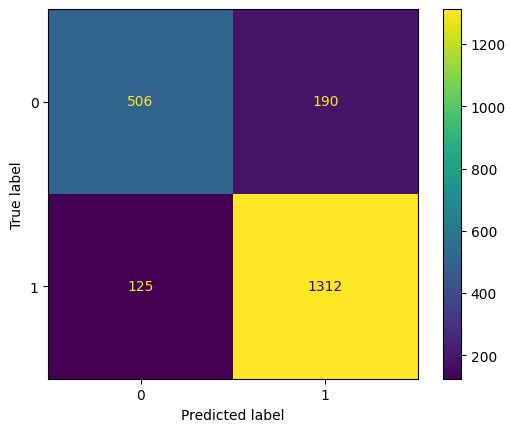

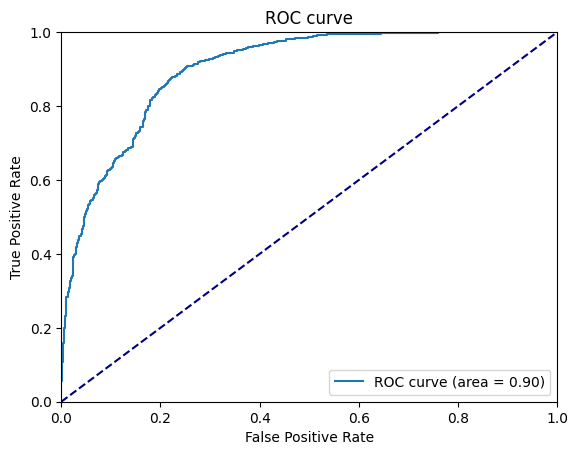

In [18]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment8_cut_feature_extraction_dropout_rms.h5'))

### Fine Tuning

#### Experiment 9: last layer

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer("sequential").layers:
    if layer.name in ('block4_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7808
Epoch 1: val_loss improved from inf to 0.45831, saving model to /content/models/experiment9_cut_finetuning_1_layer.h5
200/200 [==============================] - 45s 212ms/step - loss: 0.4843 - accuracy: 0.7808 - val_loss: 0.4583 - val_accuracy: 0.7749
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.8003
Epoch 2: val_loss improved from 0.45831 to 0.45350, saving model to /content/models/experiment9_cut_finetuning_1_layer.h5
200/200 [==============================] - 43s 215ms/step - loss: 0.4435 - accuracy: 0.8003 - val_loss: 0.4535 - val_accuracy: 0.7781
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8105
Epoch 3: val_loss improved from 0.45350 to 0.33329, saving model to /content/models/experiment9_cut_finetuning_1_layer.h5
200/200 [==============================] - 43s 213ms/step - loss: 0.4161 - accu

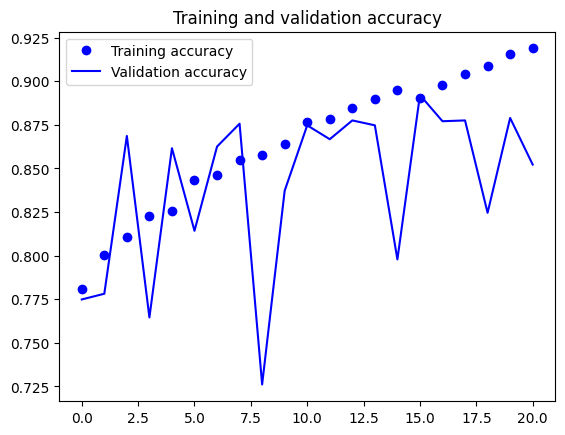

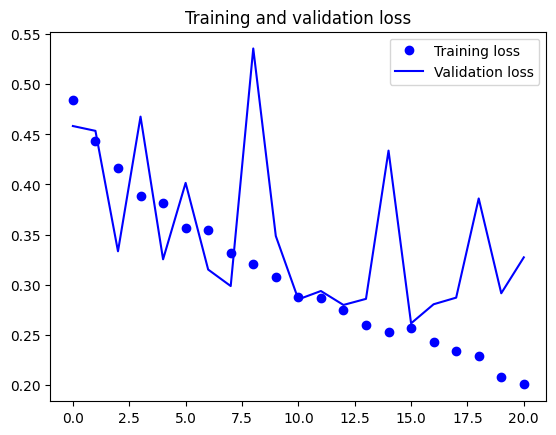

In [ ]:
run_model(vgg_ft_1_layer, 'experiment9_cut_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 138ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8584    0.8190    0.8382       696
           1     0.9142    0.9346    0.9243      1437

    accuracy                         0.8969      2133
   macro avg     0.8863    0.8768    0.8813      2133
weighted avg     0.8960    0.8969    0.8962      2133



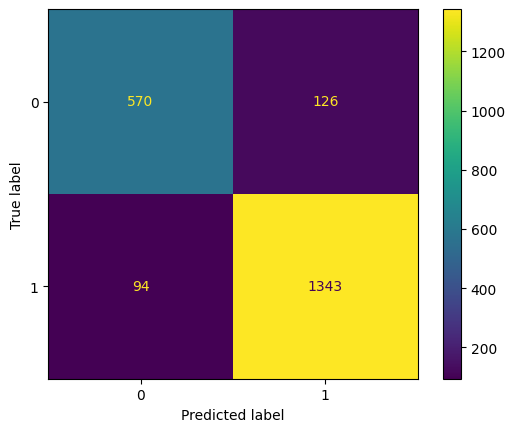

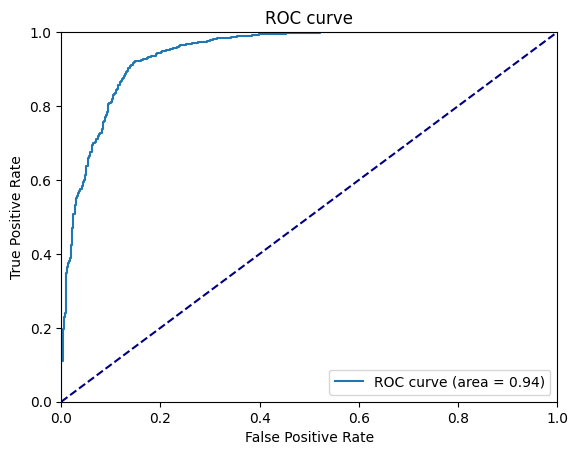

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9_cut_finetuning_1_layer.h5'))

#### Experiment 9bis: last layer

In [19]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_1_layer.get_layer("sequential").layers:
    if layer.name in ('block4_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7794
Epoch 1: val_loss improved from inf to 0.39512, saving model to /content/models/experiment9bis_cut_finetuning_1_layer.h5
200/200 [==============================] - 65s 290ms/step - loss: 0.4954 - accuracy: 0.7794 - val_loss: 0.3951 - val_accuracy: 0.8166
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.7947
Epoch 2: val_loss improved from 0.39512 to 0.37627, saving model to /content/models/experiment9bis_cut_finetuning_1_layer.h5
200/200 [==============================] - 40s 200ms/step - loss: 0.4604 - accuracy: 0.7947 - val_loss: 0.3763 - val_accuracy: 0.8321
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8032
Epoch 3: val_loss did not improve from 0.37627
200/200 [==============================] - 41s 202ms/step - loss: 0.4261 - accuracy: 0.8032 - val_loss: 0.4873 - val_accuracy: 0.7659
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8174
Epoch 4: val_loss improved from 0.37627 to 0.31582, saving model to /content/models/experiment9bis_cut_finetuning_1_layer.h5
200/200 [==============================] - 41s 206ms/step - loss: 0.4046 - accuracy: 0.8174 - val_loss: 0.3158 - val_accuracy: 0.8668
Epoch 5/100
200/200 [=

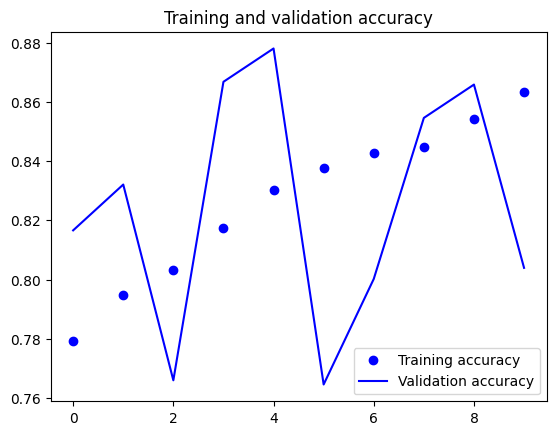

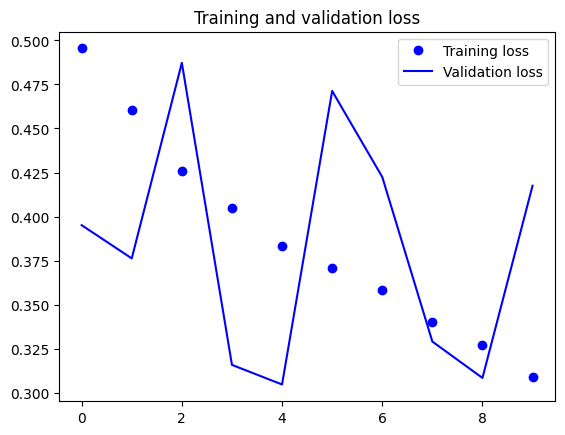

In [20]:
run_model(vgg_ft_1_layer, 'experiment9bis_cut_finetuning_1_layer', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 135ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8136    0.7586    0.7851       696
           1     0.8868    0.9158    0.9011      1437

    accuracy                         0.8645      2133
   macro avg     0.8502    0.8372    0.8431      2133
weighted avg     0.8629    0.8645    0.8632      2133



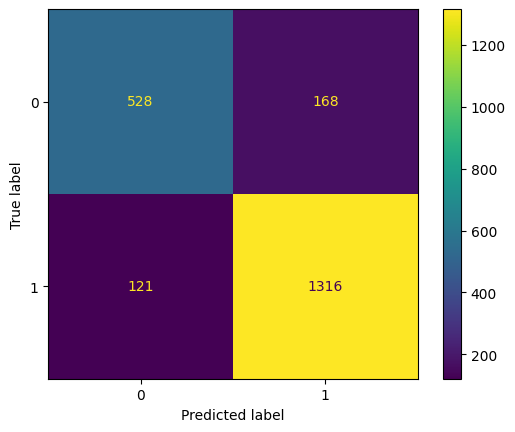

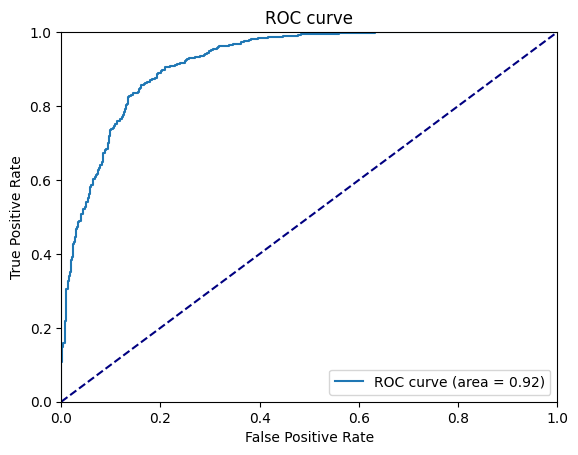

In [21]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9bis_cut_finetuning_1_layer.h5'))

#### Experiment 10: last block

In [22]:
vgg_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_block.get_layer("sequential").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_block, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_block.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7750
Epoch 1: val_loss improved from inf to 0.52108, saving model to /content/models/eperiment10_cut_ft_1_block.h5
200/200 [==============================] - 52s 248ms/step - loss: 0.4932 - accuracy: 0.7750 - val_loss: 0.5211 - val_accuracy: 0.7355
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.7983
Epoch 2: val_loss improved from 0.52108 to 0.33056, saving model to /content/models/eperiment10_cut_ft_1_block.h5
200/200 [==============================] - 49s 242ms/step - loss: 0.4317 - accuracy: 0.7983 - val_loss: 0.3306 - val_accuracy: 0.8696
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8179
Epoch 3: val_loss did not improve from 0.33056
200/200 [==============================] - 49s 243ms/step - loss: 0.3923 - accuracy: 0.8179 - val_loss: 0.3996 - val_accuracy: 0.8133
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8316
Epoch 4: val_loss improved from 0.33056 to 0.30568, saving model to /content/models/eperiment10_cut_ft_1_block.h5
200/200 [==============================] - 49s 243ms/step - loss: 0.3762 - accuracy: 0.8316 - val_loss: 0.3057 - val_accuracy: 0.8724
Epoch 5/100
200/200 [=======================

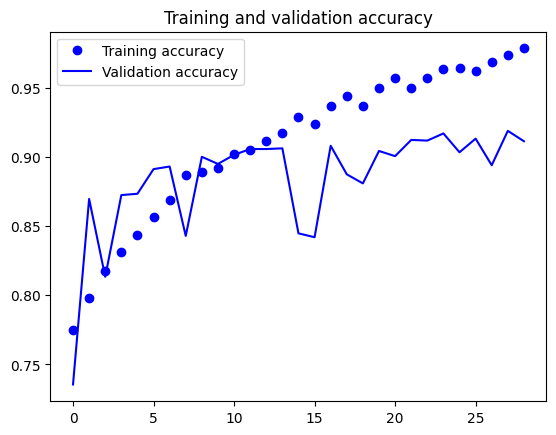

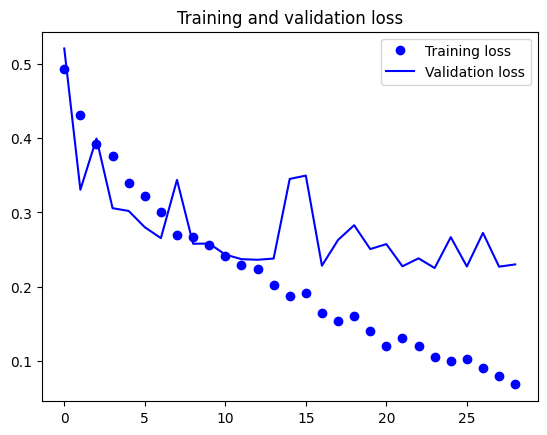

In [23]:
run_model(vgg_ft_1_block, 'eperiment10_cut_ft_1_block', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 133ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8584    0.8621    0.8602       696
           1     0.9331    0.9311    0.9321      1437

    accuracy                         0.9086      2133
   macro avg     0.8957    0.8966    0.8961      2133
weighted avg     0.9087    0.9086    0.9086      2133



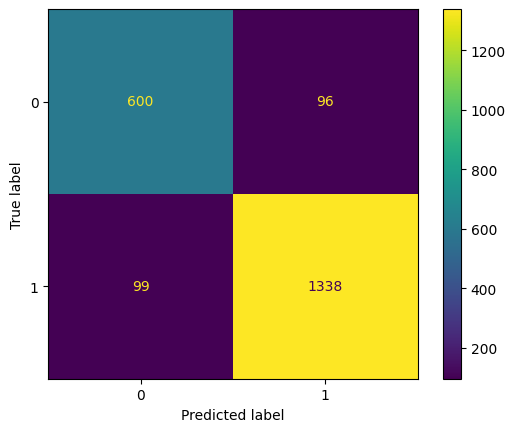

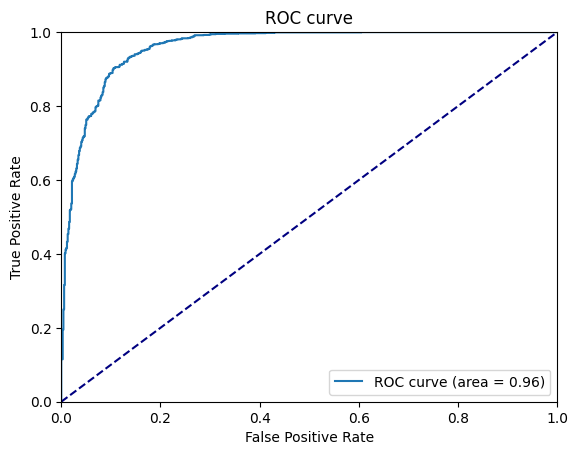

In [24]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment10_cut_ft_1_block.h5'))

#### Experiment 10bis: last block

In [25]:
vgg_ft_1_block = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_1_block.get_layer("sequential").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_block, optimizer="rms", learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_block.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.7777
Epoch 1: val_loss improved from inf to 0.38642, saving model to /content/models/eperiment10bis_cut_ft_1_block.h5
200/200 [==============================] - 38s 185ms/step - loss: 0.4993 - accuracy: 0.7777 - val_loss: 0.3864 - val_accuracy: 0.8269
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.7763
Epoch 2: val_loss improved from 0.38642 to 0.37364, saving model to /content/models/eperiment10bis_cut_ft_1_block.h5
200/200 [==============================] - 37s 185ms/step - loss: 0.4812 - accuracy: 0.7763 - val_loss: 0.3736 - val_accuracy: 0.8438
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7817
Epoch 3: val_loss did not improve from 0.37364
200/200 [==============================] - 38s 189ms/step - loss: 0.4683 - accuracy: 0.7817 - val_loss: 0.6668 - val_accuracy: 0.6506
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.7911
Epoch 4: val_loss improved from 0.37364 to 0.37267, saving model to /content/models/eperiment10bis_cut_ft_1_block.h5
200/200 [==============================] - 38s 190ms/step - loss: 0.4541 - accuracy: 0.7911 - val_loss: 0.3727 - val_accuracy: 0.8429
Epoch 5/100
200/200 [=================

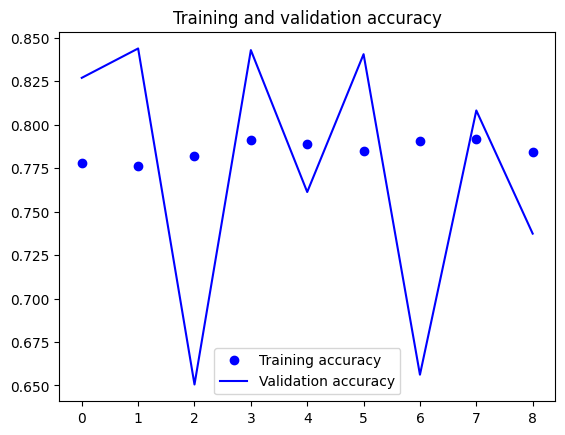

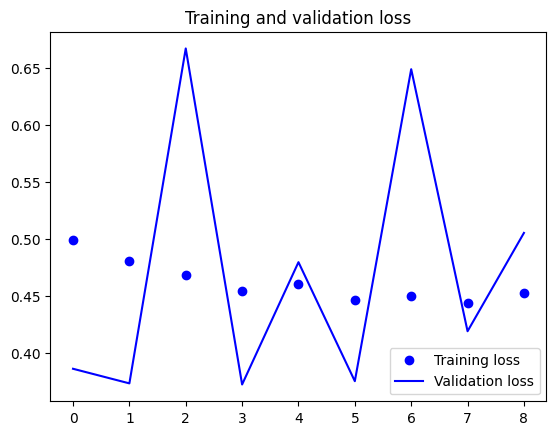

In [26]:
run_model(vgg_ft_1_block, 'eperiment10bis_cut_ft_1_block', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 135ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7361    0.7816    0.7582       696
           1     0.8910    0.8643    0.8774      1437

    accuracy                         0.8373      2133
   macro avg     0.8135    0.8230    0.8178      2133
weighted avg     0.8404    0.8373    0.8385      2133



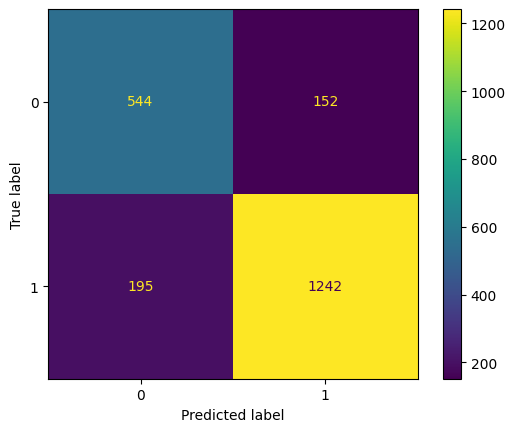

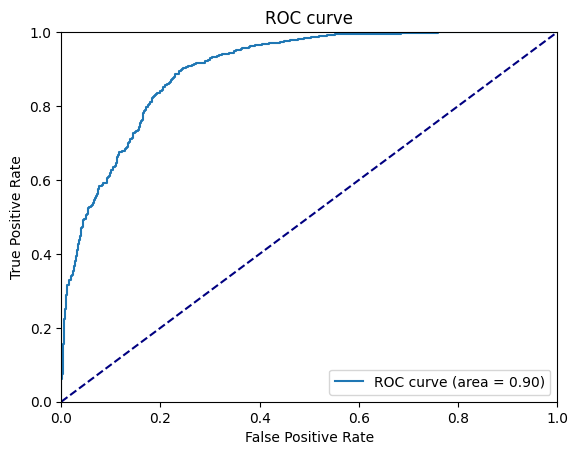

In [27]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment10bis_cut_ft_1_block.h5'))

#### Experiment 11: last two blocks

In [28]:
vgg_ft_2_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_2_blocks.get_layer("sequential").layers:
    if layer.name in ('block4_conv3', 'block4_conv1', 'block4_conv2', 'block3_conv3' , 'block3_conv2' , 'block3_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_2_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_2_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4844 - accuracy: 0.7756
Epoch 1: val_loss improved from inf to 0.39933, saving model to /content/models/eperiment11_cut_ft_2_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 72s 331ms/step - loss: 0.4844 - accuracy: 0.7756 - val_loss: 0.3993 - val_accuracy: 0.8213
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.7999
Epoch 2: val_loss improved from 0.39933 to 0.36973, saving model to /content/models/eperiment11_cut_ft_2_blocks.h5
200/200 [==============================] - 64s 320ms/step - loss: 0.4219 - accuracy: 0.7999 - val_loss: 0.3697 - val_accuracy: 0.8372
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8229
Epoch 3: val_loss improved from 0.36973 to 0.32360, saving model to /content/models/eperiment11_cut_ft_2_blocks.h5
200/200 [==============================] - 65s 324ms/step - loss: 0.3879 - accuracy: 0.8229 - val_loss: 0.3236 - val_accuracy: 0.8691
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8480
Epoch 4: val_loss improved from 0.32360 to 0.31880, saving model to /content/

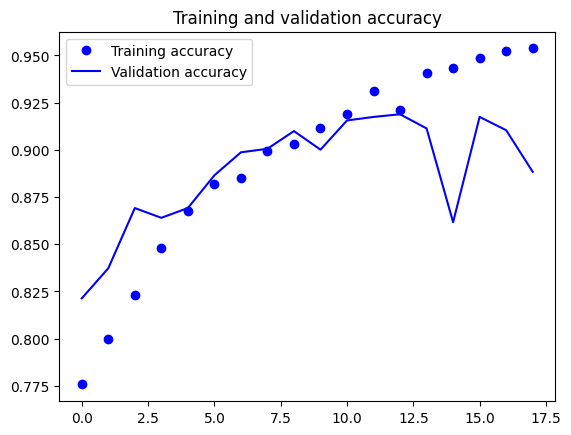

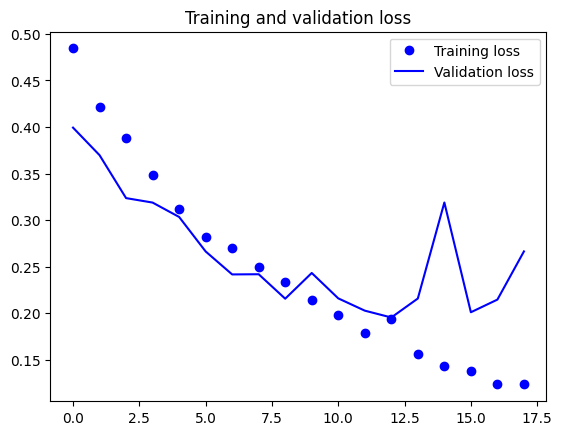

In [29]:
run_model(vgg_ft_2_blocks, 'eperiment11_cut_ft_2_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 132ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9226    0.8218    0.8693       696
           1     0.9180    0.9666    0.9417      1437

    accuracy                         0.9194      2133
   macro avg     0.9203    0.8942    0.9055      2133
weighted avg     0.9195    0.9194    0.9181      2133



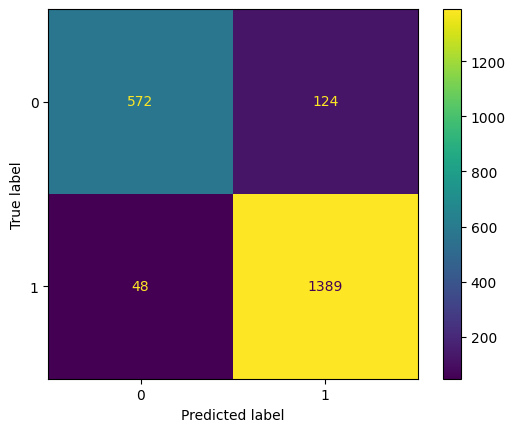

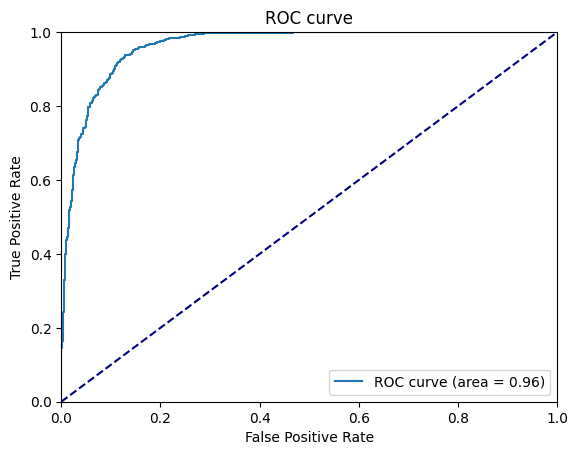

In [30]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment11_cut_ft_2_blocks.h5'))

#### Experiment 12: last three blocks

In [31]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7659
Epoch 1: val_loss improved from inf to 0.39783, saving model to /content/models/eperiment12_cut_ft_3_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 90s 413ms/step - loss: 0.5059 - accuracy: 0.7659 - val_loss: 0.3978 - val_accuracy: 0.8227
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8125
Epoch 2: val_loss improved from 0.39783 to 0.33830, saving model to /content/models/eperiment12_cut_ft_3_blocks.h5
200/200 [==============================] - 80s 397ms/step - loss: 0.4063 - accuracy: 0.8125 - val_loss: 0.3383 - val_accuracy: 0.8560
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8322
Epoch 3: val_loss improved from 0.33830 to 0.30540, saving model to /content/models/eperiment12_cut_ft_3_blocks.h5
200/200 [==============================] - 81s 403ms/step - loss: 0.3687 - accuracy: 0.8322 - val_loss: 0.3054 - val_accuracy: 0.8705
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8488
Epoch 4: val_loss improved from 0.30540 to 0.26040, saving model to /content/

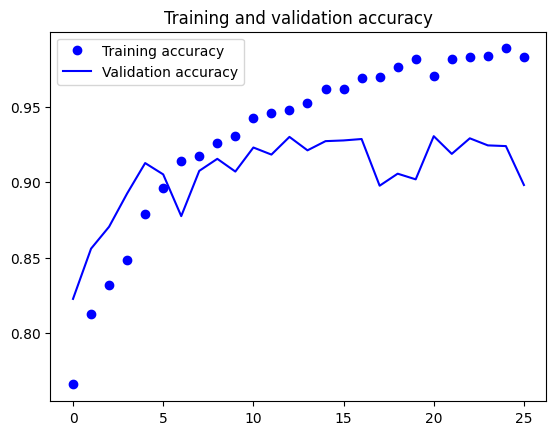

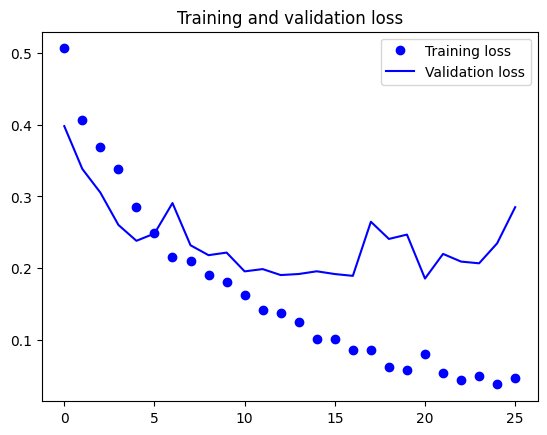

In [32]:
run_model(vgg_ft_3_blocks, 'eperiment12_cut_ft_3_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 134ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9224    0.8534    0.8866       696
           1     0.9315    0.9652    0.9481      1437

    accuracy                         0.9287      2133
   macro avg     0.9269    0.9093    0.9173      2133
weighted avg     0.9285    0.9287    0.9280      2133



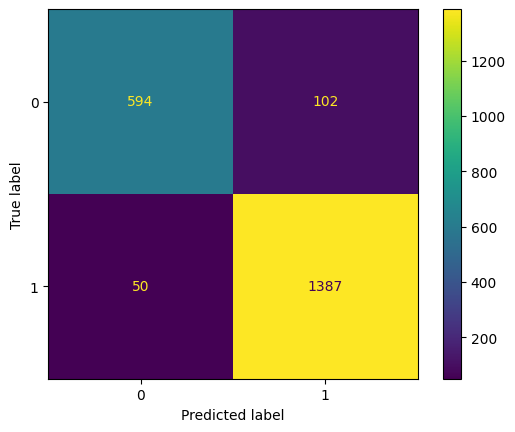

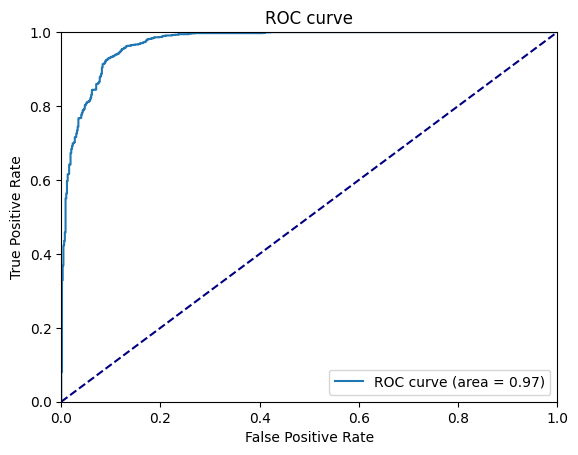

In [33]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment12_cut_ft_3_blocks.h5'))

#### Experiment 12bis: last three blocks RMSProp

In [34]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment8_cut_feature_extraction_dropout_rms.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, optimizer = "rms", learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.7780
Epoch 1: val_loss improved from inf to 0.36399, saving model to /content/models/eperiment12bis_cut_ft_3_blocks.h5
200/200 [==============================] - 38s 185ms/step - loss: 0.4938 - accuracy: 0.7780 - val_loss: 0.3640 - val_accuracy: 0.8415
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.7805
Epoch 2: val_loss did not improve from 0.36399
200/200 [==============================] - 37s 183ms/step - loss: 0.4776 - accuracy: 0.7805 - val_loss: 0.4750 - val_accuracy: 0.7735
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4701 - accuracy: 0.7797
Epoch 3: val_loss did not improve from 0.36399
200/200 [==============================] - 37s 184ms/step - loss: 0.4701 - accuracy: 0.7797 - val_loss: 0.3735 - val_accuracy: 0.8401
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.7860
Epoch 4: val_loss did not improve from 0.36399
200/200 [==============================] - 37s 183ms/step - loss: 0.4647 - accuracy: 0.7860 - val_loss: 0.4148 - val_accuracy: 0.8082
Epoch 5/100
200/200 [==============================] - ETA: 0s - loss: 0.4556 - accuracy: 0.7844
Epoch 5: val_loss improved from 0.36399 to 0.35842, saving model to /content/mode

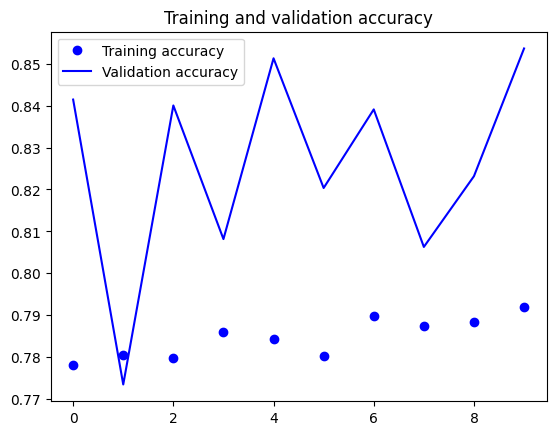

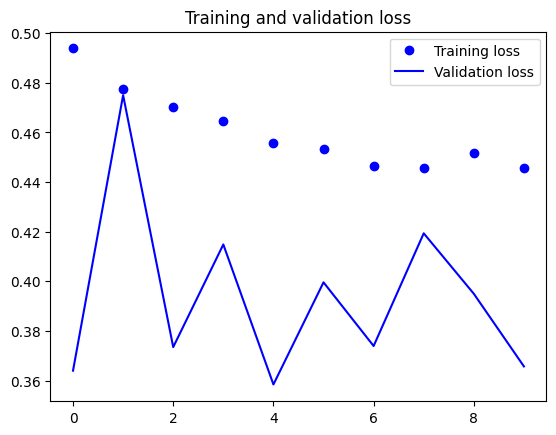

In [35]:
run_model(vgg_ft_3_blocks, 'eperiment12bis_cut_ft_3_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 134ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7899    0.7399    0.7641       696
           1     0.8778    0.9047    0.8910      1437

    accuracy                         0.8509      2133
   macro avg     0.8338    0.8223    0.8276      2133
weighted avg     0.8491    0.8509    0.8496      2133



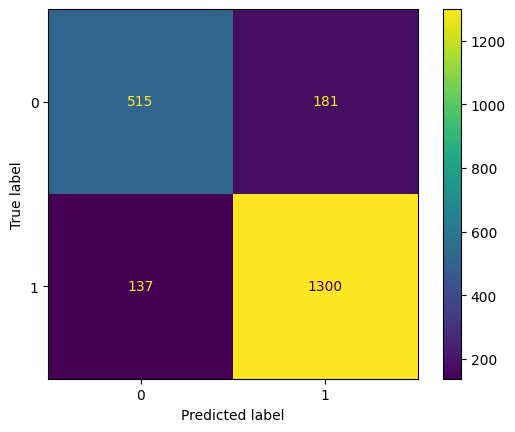

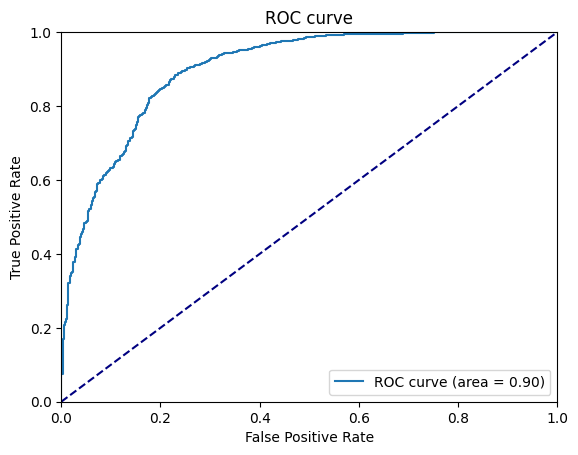

In [36]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment12bis_cut_ft_3_blocks.h5'))

#### Experiment 13: all blocks

In [38]:
vgg_ft_all_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_cut_feature_extraction_dropout.h5'))

for layer in vgg_ft_all_blocks.get_layer("sequential").layers:
    if layer.name in (''):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_all_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_all_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.7766
Epoch 1: val_loss improved from inf to 0.34278, saving model to /content/models/eperiment13_cut_ft_all_blocks.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 109s 504ms/step - loss: 0.4961 - accuracy: 0.7766 - val_loss: 0.3428 - val_accuracy: 0.8532
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8088
Epoch 2: val_loss improved from 0.34278 to 0.30523, saving model to /content/models/eperiment13_cut_ft_all_blocks.h5
200/200 [==============================] - 97s 483ms/step - loss: 0.4136 - accuracy: 0.8088 - val_loss: 0.3052 - val_accuracy: 0.8809
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3577 - accuracy: 0.8352
Epoch 3: val_loss improved from 0.30523 to 0.28977, saving model to /content/models/eperiment13_cut_ft_all_blocks.h5
200/200 [==============================] - 96s 478ms/step - loss: 0.3577 - accuracy: 0.8352 - val_loss: 0.2898 - val_accuracy: 0.8893
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8721
Epoch 4: val_loss improved from 0.28977 to 0.26015, saving model to /con

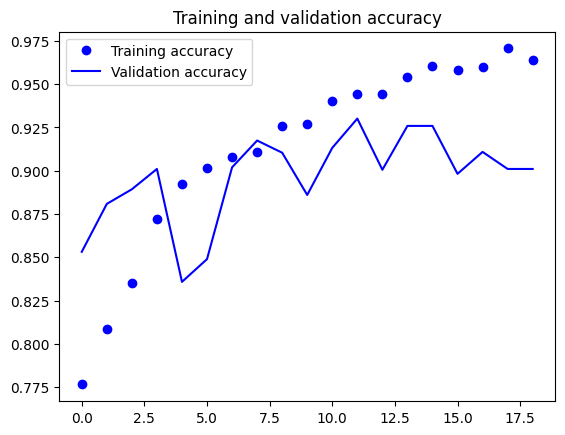

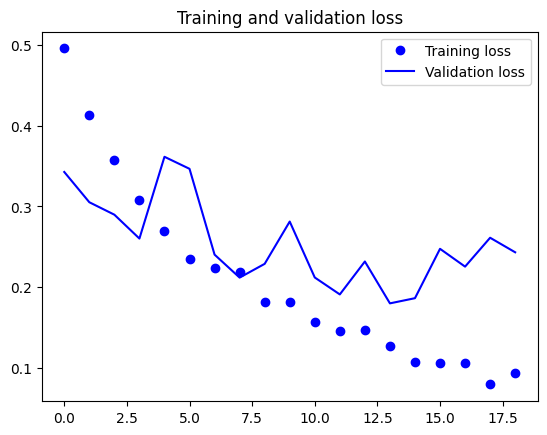

In [39]:
run_model(vgg_ft_all_blocks, 'eperiment13_cut_ft_all_blocks', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 133ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8944    0.8879    0.8911       696
           1     0.9459    0.9492    0.9476      1437

    accuracy                         0.9292      2133
   macro avg     0.9201    0.9186    0.9193      2133
weighted avg     0.9291    0.9292    0.9291      2133



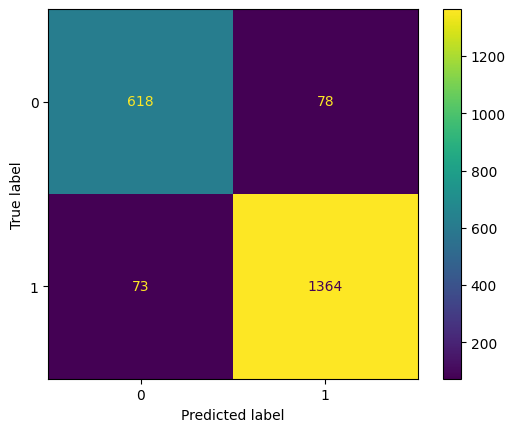

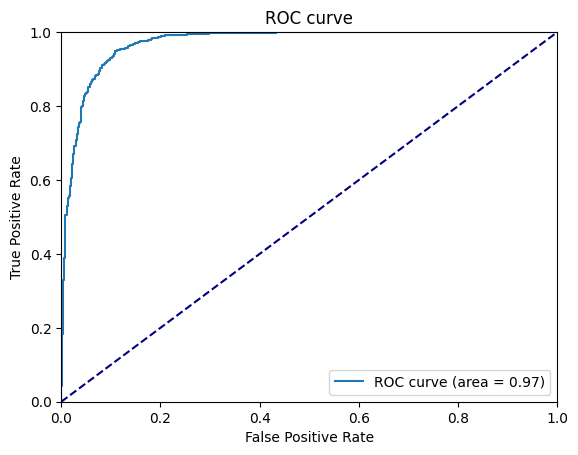

In [40]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/eperiment13_cut_ft_all_blocks.h5'))

## CLAHE
Taking the best network on the regular dataset, we evaluate whether or not adding a preprocessing step, i.e., applying CLAHE, improves performance.

In [41]:
!unzip -q "/content/drive/My Drive/SplittedDataset_CLAHE.zip" -d "/content"

In [42]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

In [43]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


### Experiment 14: Remove Last Block + Fine Tuning of last Three Blocks + CLAHE

#### Feature Extraction

In [44]:
model = Sequential()
for layer in conv_base.layers:
  if layer.name in ("block5_conv1"):
    break
  layer.trainable = False
  model.add(layer)

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [45]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_cut_model_CLAHE = keras.Model(inputs, outputs)
compile_model(vgg_cut_model_CLAHE)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 29.8574 - accuracy: 0.6477
Epoch 1: val_loss improved from inf to 6.60223, saving model to /content/models/experiment14_1_cut_feature_extraction_CLAHE.h5
200/200 [==============================] - 38s 180ms/step - loss: 29.8574 - accuracy: 0.6477 - val_loss: 6.6022 - val_accuracy: 0.7706
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 14.7672 - accuracy: 0.6896
Epoch 2: val_loss improved from 6.60223 to 5.12603, saving model to /content/models/experiment14_1_cut_feature_extraction_CLAHE.h5
200/200 [==============================] - 36s 180ms/step - loss: 14.7672 - accuracy: 0.6896 - val_loss: 5.1260 - val_accuracy: 0.8204
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 10.0273 - accuracy: 0.7008
Epoch 3: val_loss did not improve from 5.12603
200/200 [==============================] - 37s 185ms/step - loss: 10.0273 - accuracy: 0.7008 - val_loss: 8.2409 - val_accuracy: 0.6088
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 6.4397 - accuracy: 0.7117
Epoch 4: val_loss improved from 5.12603 to 2.93052, saving model to /content/models/experiment14_1_cut_feature_extraction_CLAHE.h5
200/200 [==============================] - 38s 191ms/step - loss: 6.4397 - accuracy: 0.7117 - val_loss: 2.9305 - val_accuracy: 0.7472
Epoch 

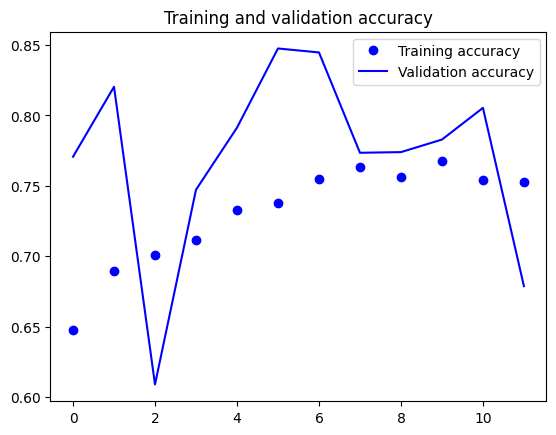

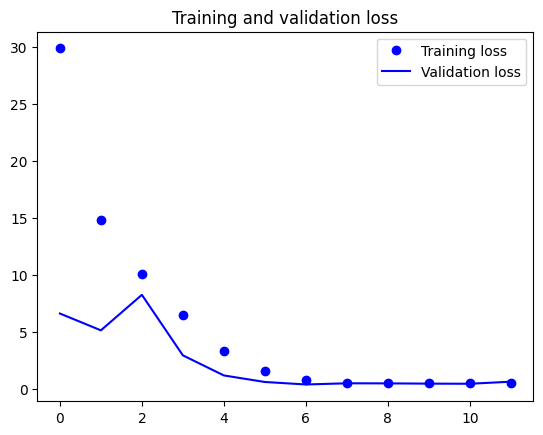

In [46]:
run_model(vgg_cut_model_CLAHE, 'experiment14_1_cut_feature_extraction_CLAHE', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 132ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7482    0.7471    0.7477       696
           1     0.8776    0.8782    0.8779      1437

    accuracy                         0.8354      2133
   macro avg     0.8129    0.8127    0.8128      2133
weighted avg     0.8354    0.8354    0.8354      2133



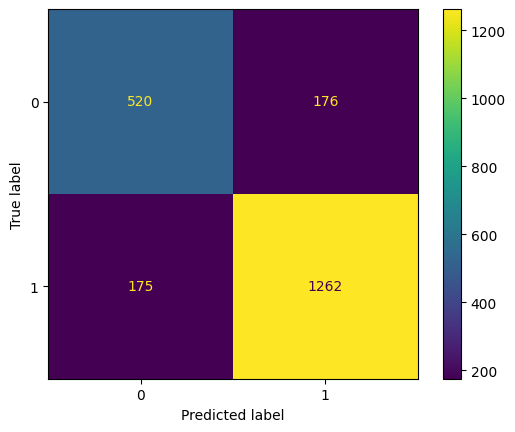

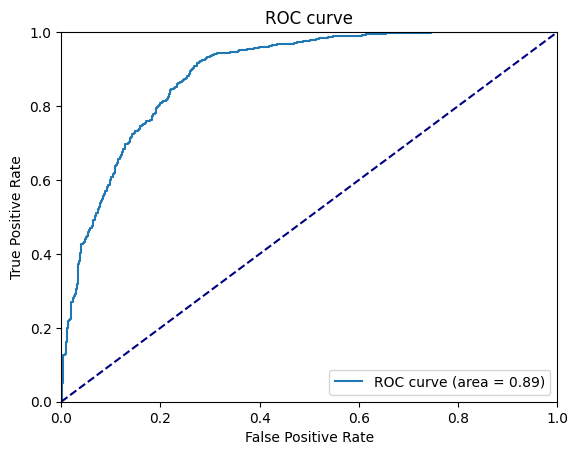

In [47]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment14_1_cut_feature_extraction_CLAHE.h5'))

#### Fine Tuning

In [49]:
vgg_ft_3_blocks = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment14_1_cut_feature_extraction_CLAHE.h5'))

for layer in vgg_ft_3_blocks.get_layer("sequential").layers:
    if layer.name in ('block1_conv2', 'block1_conv1'):
        layer.trainable = False
    else:
        layer.trainable = True

compile_model(vgg_ft_3_blocks, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_3_blocks.get_layer('sequential').layers):
    print(i, layer.name, layer.trainable)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 sequential (Sequential)     (None, 14, 14, 512)       10585152  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7650
Epoch 1: val_loss improved from inf to 0.48831, saving model to /content/models/experiment14_2_cut_finetuning_3_blocks_CLAHE.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 84s 399ms/step - loss: 0.5328 - accuracy: 0.7650 - val_loss: 0.4883 - val_accuracy: 0.7664
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8088
Epoch 2: val_loss improved from 0.48831 to 0.30833, saving model to /content/models/experiment14_2_cut_finetuning_3_blocks_CLAHE.h5
200/200 [==============================] - 80s 398ms/step - loss: 0.4142 - accuracy: 0.8088 - val_loss: 0.3083 - val_accuracy: 0.8724
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3685 - accuracy: 0.8402
Epoch 3: val_loss did not improve from 0.30833
200/200 [==============================] - 81s 402ms/step - loss: 0.3685 - accuracy: 0.8402 - val_loss: 0.3556 - val_accuracy: 0.8494
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8616
Epoch 4: val_loss improved from 0.30833 to 0.25123, saving model to /content/models/experiment14_2_cut_finetuning_3_blocks_CLAHE

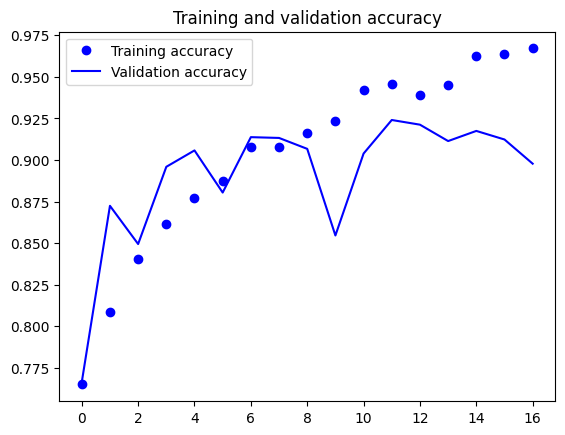

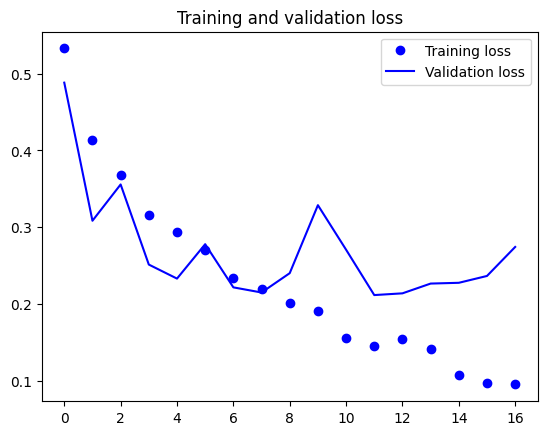

In [50]:
run_model(vgg_ft_3_blocks, 'experiment14_2_cut_finetuning_3_blocks_CLAHE', epochs = 100, patience=5, monitor='val_loss')

67/67 [==============================] - 9s 135ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9048    0.8463    0.8745       696
           1     0.9278    0.9569    0.9421      1437

    accuracy                         0.9208      2133
   macro avg     0.9163    0.9016    0.9083      2133
weighted avg     0.9203    0.9208    0.9201      2133



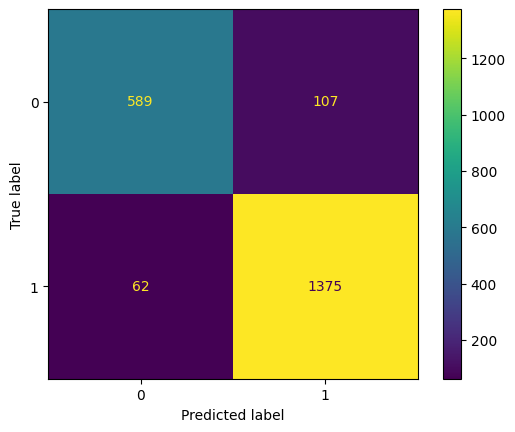

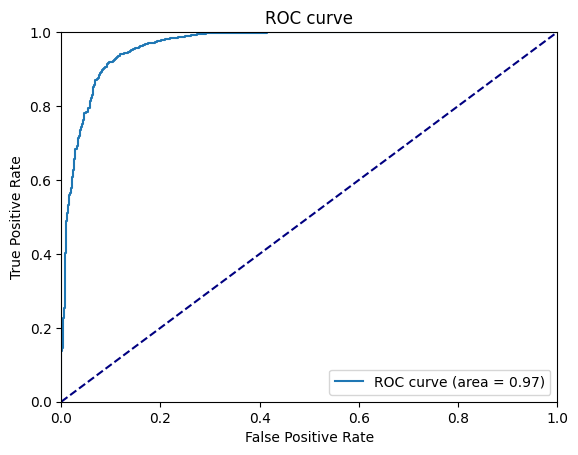

In [51]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment14_2_cut_finetuning_3_blocks_CLAHE.h5'))

As shown above, no improvement can be seen with the application of CLAHE. Perhaps all experiments should be repeated from scratch to find the best combination for the images that have been transformed in this way.